# Toxic Structures 2015

Preliminary analysis of parcel-level blood test data. Quick and dirty analysis joining test data to 2014 ownership data.

In [1]:
# import libraries
from pysqlite2 import dbapi2 as sql
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
db = "/home/eric/detroit_research_projects/data/HealthyHomes/HealthyHomes.sqlite"
con = sql.connect(db)
cur = con.cursor()

In [3]:
# how many blood test records
cur.execute("SELECT COUNT(*) FROM test_data_2015;")
results = cur.fetchall()
print results

[(3388,)]


In [4]:
# how many parcels match 2014 assessor file?
cur.execute('''
    SELECT COUNT(*) 
    FROM test_data_2015 AS A JOIN detroitparcels2014 AS B
    ON A.parcel = B.parcelnumber
    ;
    ''')
results = cur.fetchall()
print results

[(3380,)]


In [5]:
# how many of these parcels are investor owned?
# 1 = investor owned
cur.execute('''
    SELECT B.investor_flag, COUNT(*) 
    FROM test_data_2015 AS A JOIN detroitparcels2014 AS B
    ON A.parcel = B.parcelnumber
    GROUP BY B.investor_flag
    ;
    ''')
results = cur.fetchall()
for row in results:
    print row

(None, 2873)
(1, 507)


In [6]:
# what is the correspondance btw investor-ownership and elevated blood levels?
# Is 5 micrograms per deciliter the threshold of concern?
qry = '''
SELECT A.ROWID, B.investor_flag, A.bll, B.resyearbuilt, B.currentsev
FROM test_data_2015 AS A JOIN detroitparcels2014 AS B
ON A.parcel = B.parcelnumber;
'''
df = pd.read_sql(qry, con, index_col='rowid')
df.fillna(0, inplace=True)
df['ebll_flag'] = 0
df.loc[df['bll'] >= 5, 'ebll_flag'] = 1
df.head()

,investor_flag,bll,resyearbuilt,currentsev,ebll_flag
rowid,,,,,
100,0.0,2,1912,15232,0
882,0.0,3,1898,7499,0
897,0.0,2,1900,10524,0
900,0.0,3,1891,12862,0
883,1.0,1,1900,9475,0


In [7]:
df.describe()

,investor_flag,bll,resyearbuilt,currentsev,ebll_flag
count,3380.000000,3380.000000,3380.000000,3.380000e+03,3380.000000
mean,0.150000,1.837870,1749.049112,2.542542e+04,0.043787
std,0.357124,1.785903,567.848097,1.807060e+05,0.204651
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,1.000000,1918.000000,7.951250e+03,0.000000
50%,0.000000,1.000000,1928.000000,1.285200e+04,0.000000
75%,0.000000,2.000000,1946.000000,1.807650e+04,0.000000
max,1.000000,32.000000,2008.000000,8.340785e+06,1.000000


In [8]:
pd.crosstab(df['investor_flag'], df['ebll_flag'], margins=True)

ebll_flag,0,1,All
investor_flag,,,
0.0,2752,121,2873
1.0,480,27,507
All,3232,148,3380


In [9]:
# normalize by investor flag (row)
pd.crosstab(df['investor_flag'], df['ebll_flag'], margins=True, normalize='index')

ebll_flag,0,1
investor_flag,,
0.0,0.957884,0.042116
1.0,0.946746,0.053254
All,0.956213,0.043787


In [10]:
contingency = pd.crosstab(df['investor_flag'], df['ebll_flag'])
# Chi-square test of independence.
c, p, dof, expected = chi2_contingency(contingency)
print c, p, dof 
print expected

1.02473214333 0.311399155265 1
[[ 2747.2   125.8]
 [  484.8    22.2]]


In [11]:
# who owns those investor-owned properties?
cur.execute('''
    SELECT *
    FROM
    (
    SELECT B.ownername, COUNT(*) AS ebll_count
    FROM test_data_2015 AS A JOIN detroitparcels2014 AS B
    ON A.parcel = B.parcelnumber
    WHERE B.investor_flag = 1 AND A.bll >= 5
    GROUP BY B.ownername
    ORDER BY COUNT(*) DESC
    ) AS left
    JOIN
    (SELECT ownername, COUNT(*) AS tot_count
    FROM detroitparcels2014
    WHERE investor_flag = 1
    GROUP BY ownername
    ) AS right
    ON left.ownername = right.ownername
    ;
    ''')
results = cur.fetchall()
for i, row in enumerate(results):
    print i, row

0 (u'HUD', 2, u'HUD', 1609)
1 (u'ACORN INVESTMENT COMPANY', 1, u'ACORN INVESTMENT COMPANY', 99)
2 (u'BENNETT, ALLEN', 1, u'BENNETT, ALLEN', 8)
3 (u'BLEVINS PROPERTY MANAGEMENT INC', 1, u'BLEVINS PROPERTY MANAGEMENT INC', 23)
4 (u'BROWN, BEVERLY A', 1, u'BROWN, BEVERLY A', 7)
5 (u'BROWN, OLIVER', 1, u'BROWN, OLIVER', 9)
6 (u'FANNIE MAE', 1, u'FANNIE MAE', 1285)
7 (u'FEDERAL HOME LOAN', 1, u'FEDERAL HOME LOAN', 18)
8 (u'HILLBUBB LIMITED, LLC', 1, u'HILLBUBB LIMITED, LLC', 8)
9 (u'HOMESOLUTIONS PROPERTIES LLC', 1, u'HOMESOLUTIONS PROPERTIES LLC', 20)
10 (u'HSBC BANK', 1, u'HSBC BANK', 10)
11 (u'HUCULAK, JERRY J', 1, u'HUCULAK, JERRY J', 11)
12 (u'KAJA HOLDINGS, LLC', 1, u'KAJA HOLDINGS, LLC', 31)
13 (u'KING, ERNEST', 1, u'KING, ERNEST', 11)
14 (u'MANORS WORLDWIDE LLC', 1, u'MANORS WORLDWIDE LLC', 17)
15 (u'NORWEST MORTGAGE INC', 1, u'NORWEST MORTGAGE INC', 7)
16 (u'PETERSON, TRAVIS', 1, u'PETERSON, TRAVIS', 12)
17 (u'PHOENIX REAL ESTATE CO', 1, u'PHOENIX REAL ESTATE CO', 10)
18 (u'ROBINSO

In [12]:
# how many homes are missing year built?
len(df.loc[df['resyearbuilt']==0])

322

In [13]:
# gen contingency table after dropping missing values
df = df.loc[df['resyearbuilt']>0]
df.describe()

,investor_flag,bll,resyearbuilt,currentsev,ebll_flag
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,0.164487,1.844997,1933.219751,13383.170046,0.043819
std,0.370777,1.793432,16.035640,7358.466873,0.204727
min,0.000000,1.000000,1870.000000,0.000000,0.000000
25%,0.000000,1.000000,1923.000000,8789.500000,0.000000
50%,0.000000,1.000000,1931.000000,13000.000000,0.000000
75%,0.000000,2.000000,1946.000000,17747.500000,0.000000
max,1.000000,32.000000,2008.000000,61714.000000,1.000000


In [14]:
pd.crosstab(df['investor_flag'], df['ebll_flag'], margins=True)

ebll_flag,0,1,All
investor_flag,,,
0.0,2448,107,2555
1.0,476,27,503
All,2924,134,3058


In [15]:
# normalize by investor flag (row)
pd.crosstab(df['investor_flag'], df['ebll_flag'], margins=True, normalize='index')

ebll_flag,0,1
investor_flag,,
0.0,0.958121,0.041879
1.0,0.946322,0.053678
All,0.956181,0.043819


## regression analysis

regress binary outcome of ebll on investor ownership and home age

In [16]:
import statsmodels.api as sm

/home/eric/anaconda2/envs/geo/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
df['hm_age'] = 2018 - df['resyearbuilt']
df['investor_flag'] = df['investor_flag'].astype(int)
df.describe()

,investor_flag,bll,resyearbuilt,currentsev,ebll_flag,hm_age
count,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,0.164487,1.844997,1933.219751,13383.170046,0.043819,84.780249
std,0.370777,1.793432,16.035640,7358.466873,0.204727,16.035640
min,0.000000,1.000000,1870.000000,0.000000,0.000000,10.000000
25%,0.000000,1.000000,1923.000000,8789.500000,0.000000,72.000000
50%,0.000000,1.000000,1931.000000,13000.000000,0.000000,87.000000
75%,0.000000,2.000000,1946.000000,17747.500000,0.000000,95.000000
max,1.000000,32.000000,2008.000000,61714.000000,1.000000,148.000000


In [18]:
df.dtypes

investor_flag    int64
bll              int64
resyearbuilt     int64
currentsev       int64
ebll_flag        int64
hm_age           int64
dtype: object

In [19]:
ivs = ['investor_flag', 'hm_age', 'currentsev']

logit = sm.Logit(df['ebll_flag'], df[ivs])

result = logit.fit()

print result.summary()

Optimization terminated successfully.
         Current function value: 0.194628
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              ebll_flag   No. Observations:                 3058
Model:                          Logit   Df Residuals:                     3055
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:                -0.08188
Time:                        09:12:49   Log-Likelihood:                -595.17
converged:                       True   LL-Null:                       -550.13
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
investor_flag    -0.0325      0.217     -0.150      0.881      -0.458       0.393
hm_age           -0.

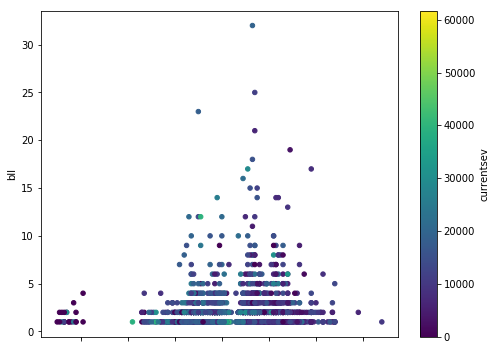

In [23]:
df.plot.scatter(x='hm_age', y='bll', c='currentsev', colormap='viridis', figsize=(8,6))

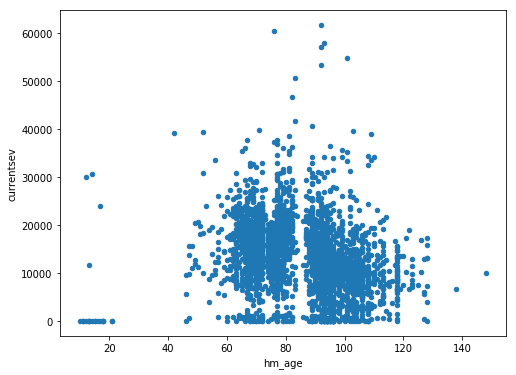

In [24]:
df.plot.scatter(x='hm_age', y='currentsev', figsize=(8,6))

In [21]:
con.close()